Clustering algorithms seek to learn, from the properties of the data, an optimal division or discrete labeling of groups of points
<br>
<br>
Many clustering clustering algorithms are available in Scikit-Learn and elsewhere, but perhaps the simplest to understand is an algorithm known as *k-means clustering*, which is implemented in `sklearn.cluster.KMeans`

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

# Introducing k-Means
- The "cluster center" is the arithmetic mean of all the points belonging to the cluster
- Each point is closer to its own cluster center than to other cluster centers

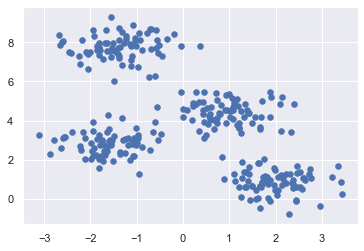

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=30);

In [3]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

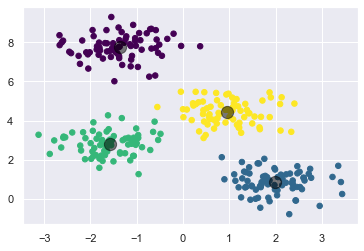

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=30, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=150, alpha=0.5);

# k-Means Algorithm: Expectation-Maximization

Expectation-maximization (E-M) is a powerful algorithm that comes up in a variety of contexts within data science

1. Guess some cluster centers
2. Repeat until converged
    1. *E-Step*: assign points to the nearest cluster center
    2. *M-Step*: set the cluster centers to the mean

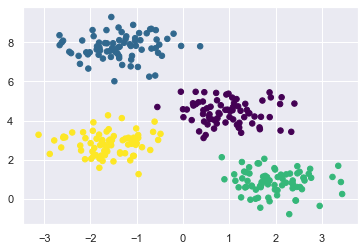

In [8]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from mean of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
        
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=30, cmap='viridis');

## Caveats of expectation-maximization
<br>
There are a few issues to be aware of when using the expectation-maximization algorithm

### The globally optimal result may not be achieved
<br>

there is no assurance that it will lead to the *global* best solution

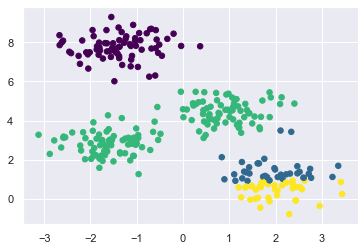

In [9]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=30, cmap='viridis');

Here the E-M approach has converged, but has not converged to a globally optimal configuration. For this reason, it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default(set by the `n_init` parameter, which defaults to 10)

### The number of clusters must be selected beforehand

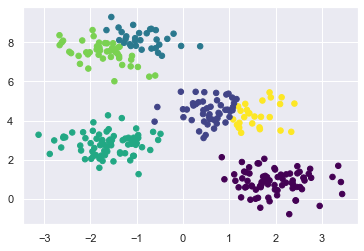

In [10]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=30, cmap='viridis');

### k-means is limited to linear cluster boundaries <br>

algorithm will often be ineffective if the clusters have complicated geometries
<br>
In particular, the boundaries between k-means clusters will always be linear, whcih means that it will fail for more complicated boundaries

In [11]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

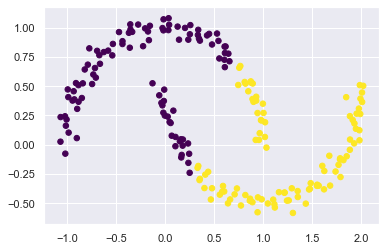

In [12]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, 
            s=30, cmap='viridis');

One version of this kernelized k-means is implemented in Scikit-Learn within the `SpectralClustering` estimator

C:\Users\imdff\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


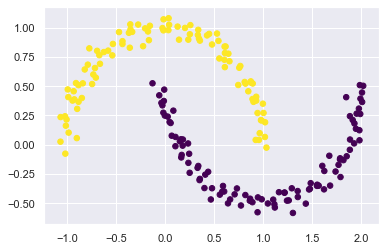

In [13]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=30, cmap='viridis');

### k-means can be slow for large numbers of samples
<br/>
Because each iteration of k-means must access every point in the dataset, the algorithm can be relatively slow as the number of samples grow
<br/>

you might just use a subset of the data to update the cluster centers at each step. which is implemented in `sklearn.cluster.MiniBatchKMeans`

# Examples

## Example 1: k-means on digits
<br>
Here we will attempt to use k-means to try to identify similar digits without using the original label information

In [14]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [15]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

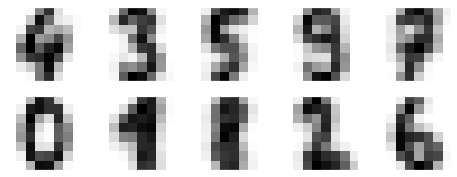

In [17]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [18]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [19]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7935447968836951

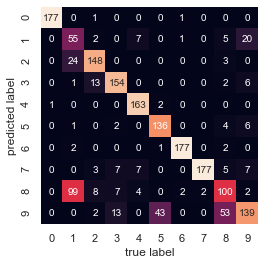

In [20]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [21]:
from sklearn.manifold import TSNE

# Porject the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Compute the cluster
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the label
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]
    
# Compute the accuracy
accuracy_score(digits.target, labels)

0.9326655537006121

## Example 2: k-means for color compression
<br>
One interesting application of clustering is in color compression within images.

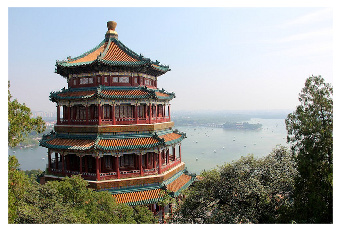

In [22]:
# Note: this requires the ``pillow`` package to be installed
from sklearn.datasets import load_sample_image
china = load_sample_image('china.jpg')
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

In [24]:
china.shape

(427, 640, 3)

In [25]:
data = china / 255.0
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

In [34]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.', s=30)
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))
    
    ax[1].scatter(R, G, color=colors, marker='.', s=30)
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))
    
    fig.suptitle(title, size=20);

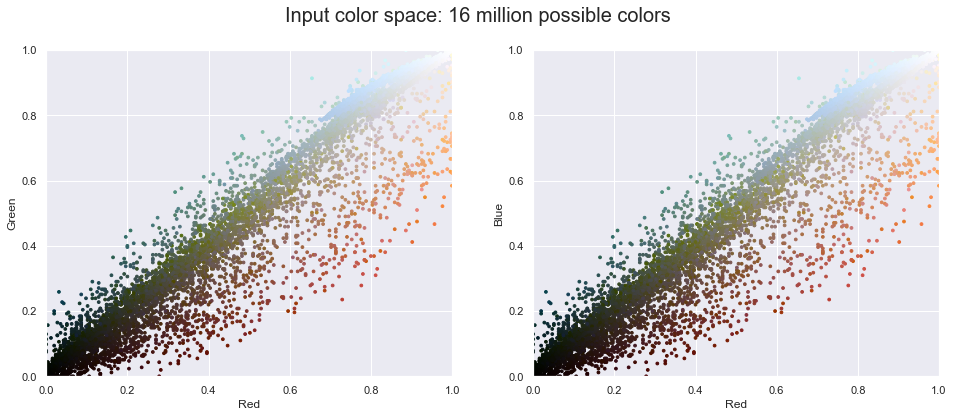

In [35]:
plot_pixels(data, title='Input color space: 16 million possible colors')

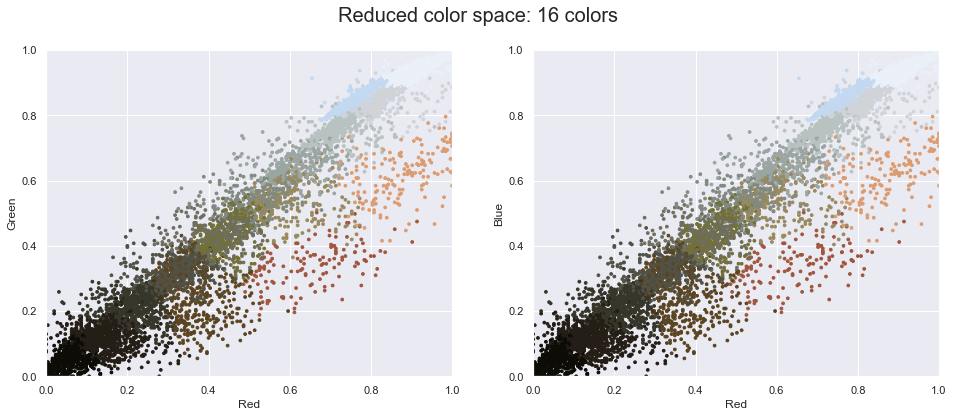

In [38]:
# import warnings; warings.simplefilter('ignore') # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title='Reduced color space: 16 colors')

Text(0.5, 1.0, '16-color Image')

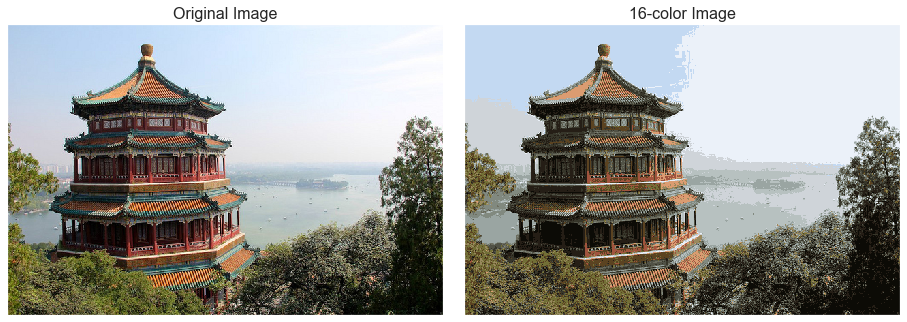

In [39]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16)

In [44]:
from sys import getsizeof
print(f'original: {getsizeof(china)} bytes,')
print(f'resized: {getsizeof(china_recolored)} bytes')
        

original: 819968 bytes,
resized: 128 bytes
